In [70]:
import os
import gc
import re
import time
import random
import numpy as np
import pandas as pd
import csv
import json
import copy
import glob
import math
import joblib
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.optim import AdamW
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors

Dataset & Dataloader

In [118]:
from sklearn.model_selection import train_test_split
dataset = pd.read_csv("/Users/shengfang/Desktop/X.051/merged_2_filtered.csv")
train_set, temp = train_test_split(dataset, test_size=0.2, random_state=42, shuffle=True)
val_set, test_set = train_test_split(temp, test_size=0.5, random_state=42, shuffle=True)

train_set = train_set.reset_index(drop=True)
val_set = val_set.reset_index(drop=True)
test_set = test_set.reset_index(drop=True)

print(val_set)

           jid  formula_spaced             element_list crystal_system  \
0  JVASP-34293       C1 Ca1 O3         ['C', 'Ca', 'O']   orthorhombic   
1  JVASP-34374      Mg2 O4 Si1        ['Mg', 'O', 'Si']       trigonal   
2  JVASP-34316  Ba1 Br1 F5 Pb2  ['Ba', 'Br', 'F', 'Pb']     tetragonal   
3  JVASP-34303      Ga4 O8 Ti1        ['Ga', 'O', 'Ti']     monoclinic   

   is_direct                                            en_list  \
0          1  [0.0, 0.015, 0.03, 0.045, 0.06, 0.075, 0.09, 0...   
1          1  [0.0, 0.015, 0.03, 0.045, 0.06, 0.075, 0.09, 0...   
2          0  [0.0, 0.015, 0.03, 0.045, 0.06, 0.075, 0.09, 0...   
3          0  [0.0, 0.015, 0.03, 0.045, 0.06, 0.075, 0.09, 0...   

                                            imag_avg  
0  [0.0, 7.575757575757574e-05, 0.000134170854271...  
1  [0.0, 6.726457399103138e-05, 0.0001, 0.0001022...  
2  [0.0, 0.00018072289156626507, 0.00041397205588...  
3  [0.0, 0.0003275109170305676, 0.000634352256186...  


In [142]:
class DataLoader():
    '''
    [Input]
    dataset_path:      Pre-loaded train/val/test dataset 
                       dataset: 'formula_spaced ', 'element_list', 'crystal_system', 'imag_avg', is_direct
                                'imag_avg': strings of Y. Y is dielectric function (a.u.), Y has constant length, covering energy(eV) range [0.,7.0,0.15]
    
    batch_size:        Batch size n.
    
    [Output]
    Xs:                Array of intensity in (n,Y,1), n = batch_size
    Ys:                Array of binary labels in (n, 0 or 1)
    formula_list:      Chemical formula for each sample
    element_list:      List of elements for each sample 
    sg_list:           Space group for each sample
    '''
    def __init__(self, dataset):
        
        self.dataset = dataset
        self.len = len(self.dataset)

    def load_data(self, batch_size = 16, shuffle=True):

        if shuffle:
            indices = np.random.permutation(self.len) 
        else:
            indices = np.arange(self.len)
        
        spectra_list = ast.literal_eval(self.dataset.iloc[0]['imag_avg'])
        spectra_len = len(spectra_list)
        
        self.Xs = np.zeros((batch_size,spectra_len,1))
        self.Ys = np.zeros((batch_size, 1))
        self.formula_list, self.element_list, self.sg_list = [], [], []

        i = 0
        while i < batch_size:
            idx = indices[i]
            sample = self.dataset.iloc[idx]
            
            formula = sample['formula_spaced']
            element_list = sample['element_list']
            sg_list = sample['crystal_system']
            spectra_list = ast.literal_eval(sample['imag_avg'])
            intensities = np.array(spectra_list)
            label = sample['is_direct']
            
            self.Xs[i, :, 0] = intensities/np.max(intensities)
            self.Ys[i] = label 

            self.formula_list.append(formula)
            self.element_list.append(element_list)
            self.sg_list.append(sg_list)

            i += 1

        return self.Xs, self.Ys, self.formula_list, self.element_list, self.sg_list

Ga4 O8 Ti1 ['Ga', 'O', 'Ti'] monoclinic [0.]
Ba1 Br1 F5 Pb2 ['Ba', 'Br', 'F', 'Pb'] tetragonal [0.]
Mg2 O4 Si1 ['Mg', 'O', 'Si'] trigonal [1.]


Text(0, 0.5, 'Normalized intensity')

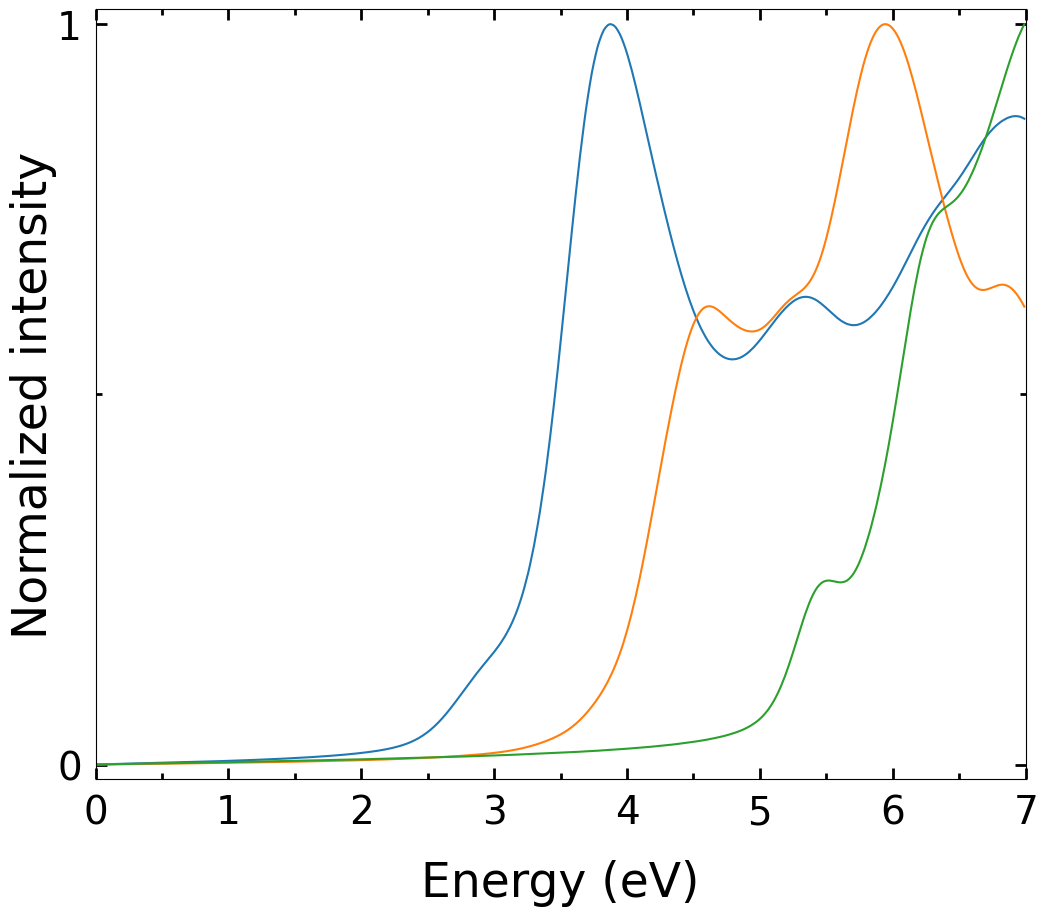

In [156]:
val_loader = DataLoader(val_set)
val_Xs, val_Ys, val_formula_list, val_element_list, val_sg_list = val_loader.load_data(batch_size = 3, shuffle=True)

fig, ax = plt.subplots(figsize=(12, 10))

for i in range(len(val_formula_list)):
    ax.plot(np.arange(0.00, 7.00, 0.015), val_Xs[i])
    print(val_formula_list[i], val_element_list[i], val_sg_list[i], val_Ys[i])
    
ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=7, steps=[1, 2, 5, 10]))
ax.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=1, steps=[1, 2, 5, 10]))
ax.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
ax.tick_params(axis='both',direction='in',length=8,width=2,pad=10,color='black',right='on',top='on',labelsize=28)
ax.tick_params(axis='both',which='minor',direction='in',length=4,width=2,pad=10,color='black',right='on',top='on',labelsize=28)
    
ax.axes.set_xlim([0.,7.])
ax.axes.set_ylim([-0.02,1.02])

ax.set_xlabel(r'Energy (eV)', labelpad=20, fontsize=34)
ax.set_ylabel(r'Normalized intensity', labelpad=0, fontsize=34)

In [158]:
train_loader = DataLoader(train_set)
val_loader = DataLoader(val_set)
test_loader = DataLoader(test_set)

In [176]:
pip install transformers==4.37.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 19.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 17.4 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.21.1
    Uninstalling tokenizers-0.21.1:
      Successfully uninstalled tokenizers-0.21.1
  Attempting uninstall: transformers
    Found existing installation: transformers 4.51.3
    Uninstalling transformers-4.51.3:
      Successfully uninstalled transformers-4.51.3
Note: you may need to restart the kernel to use updated packages.


In [183]:
import torch
import torch.nn as nn
from transformers import VisualBertConfig, VisualBertModel, AdamW
import numpy as np
import os
import joblib

visual_embedding_dim = 20
configuration = VisualBertConfig(
    vocab_size=len(tokenizer),
    visual_embedding_dim=visual_embedding_dim,
    hidden_size=int(val_Xs.shape[1] / visual_embedding_dim),  # Ensure this is valid for your input shape
    num_attention_heads=1,
    num_labels=1,  # For binary classification (0 or 1)
)
print(configuration)
class VisualBertClassifier(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.visual_bert = VisualBertModel(config)
        self.classifier = nn.Linear(config.hidden_size, 1)  # Binary classification
        self.sigmoid = nn.Sigmoid()

    def forward(self, input_ids=None, attention_mask=None, token_type_ids=None, visual_embeds=None, visual_attention_mask=None):
        outputs = self.visual_bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            visual_embeds=visual_embeds,
            visual_attention_mask=visual_attention_mask
        )
        pooled_output = outputs.pooler_output
        logits = self.classifier(pooled_output)
        return logits
        
# model = VisualBertClassifier(configuration).to('cuda')
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
model = VisualBertClassifier(configuration).to(device)  ### Running with Macbook
optimizer = AdamW(model.parameters(), lr=1e-4)
loss_fn = nn.BCEWithLogitsLoss()

VisualBertConfig {
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "bypass_transformer": false,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 23,
  "id2label": {
    "0": "LABEL_0"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "visual_bert",
  "num_attention_heads": 1,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "special_visual_initialize": true,
  "transformers_version": "4.44.2",
  "type_vocab_size": 2,
  "visual_embedding_dim": 20,
  "vocab_size": 30522
}



/Users/shengfang/anaconda3/envs/visualbert/lib/python3.12/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warmup_init=False,


In [215]:
epochs = 5000
save_training_results = False
save_epochs = [1000, 2000, 3000, 4000, 5000]

model_folder = r'/Users/shengfang/Desktop/X.051'

train_losses,train_y_true,train_y_pred = [],[],[]
val_losses,val_y_true,val_y_pred = [],[],[]
for epoch in range(epochs):
    model.train()
    train_Xs, train_Ys, train_formula_list, train_element_list, train_sg_list = train_loader.load_data(batch_size = 20, shuffle=True)
    len_dim = (train_Xs.shape[1] // visual_embedding_dim) * visual_embedding_dim
    train_Xs = train_Xs[:, :len_dim,:]  # (20, 467, 1) → (20, 460, 1)
    train_Xs = train_Xs[:,:,:].reshape((train_Xs.shape[0],int(train_Xs.shape[1]/visual_embedding_dim),visual_embedding_dim))
    
    X_prompts = [f"{formula} {' '.join(elems)} {sg}" for formula, elems, sg in zip(train_formula_list, train_element_list, train_sg_list)]

    visual_embeds = torch.from_numpy(train_Xs).to(dtype=torch.float32)
    visual_attention_mask = torch.ones(visual_embeds.shape[:-1], dtype=torch.long)
    # visual_token_type_ids = torch.ones(visual_embeds.shape[:-1], dtype=torch.long)
            
    inputs = tokenizer(X_prompts, return_tensors="pt", padding=True)
    inputs.update(
        {
            "visual_embeds": visual_embeds,
            # "visual_token_type_ids": visual_token_type_ids,
            "visual_attention_mask": visual_attention_mask,
        }
    )
    
    labels = torch.from_numpy(np.array(train_Ys)).to(dtype=torch.float32)

    # outputs = model(**inputs.to('cuda'))
    outputs = model(**inputs.to(device))
    logits = outputs
    # loss = loss_fn(logits, labels.to('cuda'))
    loss = loss_fn(logits, labels.to(device))
    
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    y_true = np.array(labels)
    y_pred = torch.sigmoid(logits).detach().cpu().numpy()
    if save_training_results:
        train_y_true.append(y_true)
        train_y_pred.append(y_pred)
    
    if (epoch+1)%10 == 0:
        # print('{}\t{:.5f}\t{}'.format(epoch+1, np.array(loss.detach().cpu()), y_true, y_pred))
        print(f"Epoch {epoch+1}\tLoss: {loss.item():.5f}")
        print(y_true,y_pred)
    train_losses.append(np.array(loss.detach().cpu()))
    
    if epoch in save_epochs:
        # model.save_pretrained(os.path.join(model_folder, '{}'.format(epoch)), from_pt=True)
        torch.save(model.state_dict(), os.path.join(model_folder, f"{epoch}_model.pt"))
        np.savetxt(os.path.join(model_folder, 'train_loss.csv'), train_losses, delimiter=',')
        print('Save model for epoch: {}'.format(epoch))
        if save_training_results:
            with open(os.path.join(model_folder, 'train_result.npy'), 'wb') as handle:
                joblib.dump({'y_true':train_y_true, 'y_pred':train_y_pred, 'loss':train_losses}, handle)


    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # Disable gradients during validation
        val_Xs, val_Ys, val_formula_list, val_element_list, val_sg_list = val_loader.load_data(batch_size = 2, shuffle=True)
        len_dim = (val_Xs.shape[1] // visual_embedding_dim) * visual_embedding_dim
        val_Xs = val_Xs[:, :len_dim,:]  # (20, 467, 1) → (20, 460, 1)
        val_Xs = val_Xs[:,:,:].reshape((val_Xs.shape[0],int(val_Xs.shape[1]/visual_embedding_dim),visual_embedding_dim))
        # Prepare validation inputs
        X_prompts_val = [f"{formula} {' '.join(elems)} {sg}" for formula, elems, sg in zip(val_formula_list, val_element_list, val_sg_list)]

        val_visual_embeds = torch.from_numpy(val_Xs).to(dtype=torch.float32)
        val_attention_mask = torch.ones(val_visual_embeds.shape[:-1], dtype=torch.long)
        # val_token_type_ids = torch.ones(val_visual_embeds.shape[:-1], dtype=torch.long).to('cuda')
            
        val_inputs = tokenizer(X_prompts_val, return_tensors="pt", padding=True)
        val_inputs.update({
            "visual_embeds": val_visual_embeds,
            # "visual_token_type_ids": val_token_type_ids,
            "visual_attention_mask": val_attention_mask,
        })

        # Validation labels
        val_labels = torch.from_numpy(np.array(val_Ys)).to(dtype=torch.float32)

        # Forward pass for validation
        # val_outputs = model(**val_inputs.to('cuda'))
        val_outputs = model(**val_inputs.to(device))
        val_logits = val_outputs
        # loss = loss_fn(val_logits, val_labels.to('cuda'))
        val_loss = loss_fn(val_logits, val_labels.to(device))

        y_true_val = np.array(val_labels)
        y_pred_val = torch.sigmoid(val_logits).detach().cpu().numpy()
        if save_training_results:
            val_y_true.append(y_true_val)
            val_y_pred.append(y_pred_val)
        if (epoch+1)%10 == 0:
            # print('{}\t{:.5f}\t{}'.format(epoch+1, np.array(val_loss.detach().cpu())))
            print(f"Epoch {epoch+1}\tLoss: {val_loss.item():.5f}")
        val_losses.append(np.array(val_loss.detach().cpu()))

    if epoch in save_epochs: 
        np.savetxt(os.path.join(model_folder, 'val_loss.csv'), val_losses, delimiter=',')

Epoch 10	Loss: 0.00864
[[0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]] [[0.00714583]
 [0.98801744]
 [0.00714135]
 [0.988     ]
 [0.00710708]
 [0.00704729]
 [0.9878681 ]
 [0.00706006]
 [0.00706054]
 [0.00718881]
 [0.00707706]
 [0.00710052]
 [0.00709343]
 [0.9878762 ]
 [0.98805106]
 [0.00711356]
 [0.00718196]
 [0.00724025]
 [0.98787665]
 [0.00704862]]
Epoch 10	Loss: 0.00949
Save model for epoch: 10
Epoch 20	Loss: 0.00853
[[0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]] [[0.00701689]
 [0.00704639]
 [0.9880199 ]
 [0.9880535 ]
 [0.00698705]
 [0.00705307]
 [0.00696501]
 [0.0070476 ]
 [0.9880959 ]
 [0.00697251]
 [0.00698719]
 [0.00701506]
 [0.0069556 ]
 [0.0070043 ]
 [0.00703598]
 [0.98804796]
 [0.00704819]
 [0.9881719 ]
 [0.00707728]
 [0.9880535 ]]
Epoch 20	Loss: 2.48839
Epoch 30	Loss: 0.00873
[[0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [

In [ ]:
model.load_state_dict(torch.load("##load model##"))
model.to(device)
model.eval()
test_y_true,test_y_pred= [],[]
with torch.no_grad():
    test_Xs, test_Ys, test_formula_list, test_element_list, test_sg_list = test_loader.load_data(batch_size=len(test_loader.dataset), shuffle=False)

    len_dim = (test_Xs.shape[1] // visual_embedding_dim) * visual_embedding_dim
    test_Xs = test_Xs[:, :len_dim, :]
    test_Xs = test_Xs.reshape((test_Xs.shape[0], -1, visual_embedding_dim))

    test_prompts = [f"{formula} {' '.join(elems)} {sg}" for formula, elems, sg in zip(test_formula_list, test_element_list, test_sg_list)]

    test_visual_embeds = torch.from_numpy(test_Xs).to(dtype=torch.float32)
    test_attention_mask = torch.ones(test_visual_embeds.shape[:-1], dtype=torch.long)

    test_inputs = tokenizer(test_prompts, return_tensors="pt", padding=True)
    test_inputs = {k: v.to(device) for k, v in test_inputs.items()}
    test_inputs.update({
        "visual_embeds": test_visual_embeds,
        "visual_attention_mask": test_attention_mask,
    })

    test_labels = torch.from_numpy(np.array(test_Ys)).to(dtype=torch.float32)

    test_logits = model(**test_inputs)
    test_loss = loss_fn(test_logits, test_labels)

    y_true_test = test_labels.cpu().numpy()
    y_pred_test = torch.sigmoid(test_logits).detach().cpu().numpy()

    test_y_true.append(y_true_test)
    test_y_pred.append(y_pred_test)

print(test_y_true, test_y_pred)